In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Input
import yfinance as yf
import matplotlib.pyplot as plt

In [10]:

# Fetch stock data from yfinance
ticker = 'AAPL'  # Replace with the stock ticker of your choice (e.g., 'MSFT', 'GOOGL')
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')
data = data[['Close']]  # Use the 'Close' column for prediction


# View the data
data.head()



[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2020-01-02 00:00:00+00:00,75.087502
2020-01-03 00:00:00+00:00,74.357498
2020-01-06 00:00:00+00:00,74.949997
2020-01-07 00:00:00+00:00,74.597504
2020-01-08 00:00:00+00:00,75.797501


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.2156 - val_loss: 0.0102
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0078 - val_loss: 0.0045
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0

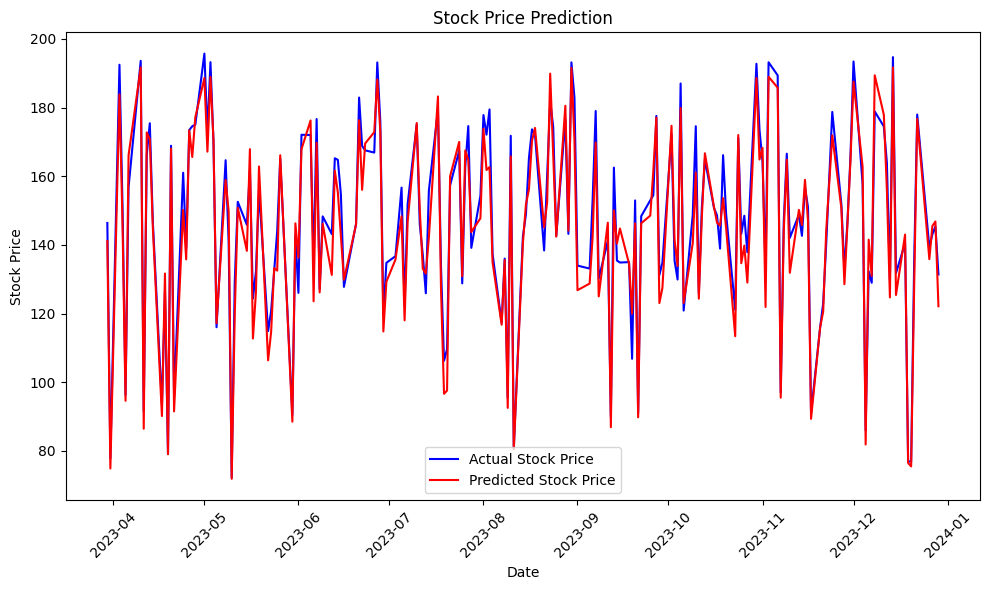

In [11]:
# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 60  # Look-back period

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Definition
model = Sequential()

# Explicit Input layer
model.add(Input(shape=(X_train.shape[1], 1)))

# CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))

# Fully connected layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict and inverse transform to original scale
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Inverse transform the test data (original values)
original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Get the dates corresponding to the test set
test_dates = data.index[sequence_length:][X_train.shape[0]:]

# Create a DataFrame to compare actual and predicted stock prices with dates
comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Stock Price": original_y_test.flatten(),
    "Predicted Stock Price": predictions.flatten()
})

# Save the comparison table to a CSV file (optional)
comparison_df.to_csv("stock_price_comparison_with_dates.csv", index=False)

# Print the first few rows of the comparison DataFrame
print(comparison_df.head())

# Calculate evaluation metrics
mse = mean_squared_error(original_y_test, predictions)
mae = mean_absolute_error(original_y_test, predictions)
r2 = r2_score(original_y_test, predictions)
rmse = np.sqrt(mse)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-Squared (R2):", r2)

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(test_dates, original_y_test, color='blue', label='Actual Stock Price')
plt.plot(test_dates, predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()